<a href="https://colab.research.google.com/github/SHplusR/MAI-ML/blob/main/hyol_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **기본 환경설정**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

In [ ]:
import re
import numpy as np

In [ ]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

pg_path = '/content/packages'

os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', pg_path)
sys.path.insert(0, pg_path)

Mounted at /content/drive


In [ ]:
from konlpy.tag import Okt

In [ ]:
#22번줄 하면 안해도됩니다. 혹시 모르니 남겨놓습니다
!pip install --target=$my_path konlpy

In [ ]:
#22번줄 하면 안해도됩니다.혹시 모르니 남겨놓습니다
!pip install --target=$my_path git+https://github.com/haven-jeon/PyKoSpacing.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-dn_fgsfv
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-dn_fgsfv
     |████████████████████████████████| 671.4 MB 1.5 kB/s 
  Using cached h5py-3.1.0-cp37-cp37m-manylinux1_x86_64.whl (4.0 MB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Using cached cached_property-1.5.2-py2.py3-none-any.whl (7.6 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached libclang-14.0.6-py2.py3-none-manylinux2010_x86_64.whl (14.1 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Using cached termcolor-2.0.1-py3-none-any.whl (5.4 kB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Using cached gast-0.4.0-py3-none-any.w

In [ ]:
# 형태소 분석때 이미 분해를 하기 때문에 필요없습니다만 혹시 몰라 남겨둡니다
from pykospacing import Spacing

KeyboardInterrupt: ignored

## **파일불러오기 및 확인**

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/data/final_nonnil_s.csv'

In [ ]:
data = pd.read_csv(filename)
data.head()

,id,review,label
0,0,눈 똥그란 간호사님 넘 친절해요....이쁘시구,1
1,1,사마귀빼러갔는데 잘해주셨습니다상담해주는 간호사님이 친절해서 더좋았습니다,1
2,2,ㅋㅋㅋ뭐야 밑에 리뷰작업하네 넘 티나자나 ~~,0
3,3,이 병원에서 근무하는 정기석 교수 🐶🦅끼 왜 실내&대중교통 마스크 의무 착용 전면 ...,0
4,4,다들 똑같습니다!허나 뇌종양은 처음 수술하신분이 다른쪽에있다가 그쪽으로 가셔서!저또...,0


In [ ]:
type(data)

pandas.core.frame.DataFrame

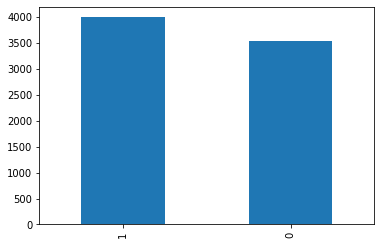

In [ ]:
data['label'].value_counts().plot(kind='bar')

In [ ]:
print(data.isnull().values.any())

False


## 데이터 나누기 ( train, test, val ) and 데이터 **정제작업**

In [ ]:
data.drop_duplicates(subset = ['review'], inplace=True) # review 열에서 중복적 내용은 제거
data['review'] = data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글 빼고 다 삭제
data['review'] = data['review'].str.replace('^ +', "") # 공백 -> empty
data['review'].replace('', np.nan, inplace=True) # 공백 -> nil
data = data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(data))

전처리 후 테스트용 샘플의 개수 : 7149


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from sklearn.model_selection import train_test_split

target = data['label']

train_data, test_data, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

print(len(train_data))
print(len(test_data))


5719
1430


In [ ]:
print(len(y_test))
print(y_test.isnull().values.any())

1430
False


In [ ]:
okt = Okt()
X_train = []
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다','로','것','고','원']
for sentence in tqdm(train_data['review']):
    tokenized_sentence = okt.morphs(str(sentence), stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)
print(X_train[:3])

100%|██████████| 5719/5719 [00:45<00:00, 124.38it/s]

[['북한', '산', '또', '다른', '모습', '을', '볼', '수', '있다', '좋다'], ['방이', '라', '적히다', '옛날', '오락실', '손님', '많다', '사장', '님', '친절하다', '심'], ['졸업', '여전하다', '그립다', '곳']]


In [ ]:
X_test = []
for sentence in tqdm(test_data['review']):
    tokenized_sentence = okt.morphs(str(sentence), stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)
print(X_test[:3])

100%|██████████| 1430/1430 [00:07<00:00, 180.09it/s]

[['그지같다', '피시방', '맨날', '신분증', '확인', '하', '피시방', '임', '가지', '말다', '시설', '구리', '음식', '맛없다', '알바생', '부터가', '전', '나', '싸가지', '없다', '누가', '가다'], ['사장', '님', '친절하다', '알바', '친절', '방', '깨끗하다', '먹다', '많다', '좋다', '근데', '화장실', '더럽다', '변기', '사용', '힘들다'], ['왜', '이렇게', '불친절하다', 'ㅠㅠ', '혼나다', '간', '기분', '이네', '요']]


# **정수인코딩**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'있다': 1, '좋다': 2, '을': 3, '없다': 4, '보다': 5, '가다': 6, '안': 7, '친절하다': 8, '너무': 9, '분': 10, '에서': 11, '직원': 12, '시간': 13, '되다': 14, '다': 15, '이다': 16, '받다': 17, '사람': 18, '곳': 19, '만': 20, '않다': 21, '많다': 22, '같다': 23, '병원': 24, '아니다': 25, '하고': 26, '해주다': 27, '오다': 28, '때': 29, '요': 30, '다른': 31, '님': 32, '여기': 33, '자다': 34, '일': 35, '진료': 36, '못': 37, '진짜': 38, '말': 39, '의사': 40, '그': 41, '책': 42, '나오다': 43, '적': 44, '안되다': 45, '알다': 46, '그렇다': 47, '나': 48, '들다': 49, '서': 50, '수': 51, '먹다': 52, '정말': 53, '그냥': 54, '까지': 55, '시': 56, '내': 57, '분들': 58, '중': 59, '함': 60, '불친절하다': 61, '더': 62, '모르다': 63, '인': 64, '영화': 65, '왜': 66, '주차': 67, '환자': 68, '정도': 69, '간호사': 70, '맛있다': 71, '싶다': 72, '하': 73, '인데': 74, '많이': 75, '기분': 76, '고객': 77, '생각': 78, '주다': 79, '기다리다': 80, '방문': 81, '되어다': 82, '지': 83, '주차장': 84, '대': 85, '사장': 86, '점': 87, '크다': 88, '게': 89, '말다': 90, '저': 91, '갈다': 92, '번': 93, '개': 94, '제': 95, '하나': 96, '검사': 97, '선생님': 98, '설명': 99, '별로': 100, '시설': 101, '이라': 102, '

In [ ]:
# 빈도 횟수가 1회 이하는 제거하기

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작을 때
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11635
등장 빈도가 1번 이하인 희귀 단어의 수: 5472
단어 집합에서 희귀 단어의 비율: 47.030511388053284
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6241602230954495


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6164


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])

[[2299, 198, 186, 31, 895, 3, 324, 51, 1, 2], [969, 152, 1736, 858, 2987, 145, 22, 86, 32, 8, 379], [2577, 1507, 2988, 19]]


In [ ]:
print(X_test[:3])

[[2013, 275, 1173, 2700, 239, 73, 275, 127, 184, 90, 101, 3233, 147, 667, 264, 2593, 131, 48, 337, 4, 843, 6], [86, 32, 8, 143, 248, 392, 171, 52, 22, 2, 355, 179, 417, 2534, 386, 202], [66, 265, 61, 209, 2605, 451, 76, 262, 30]]


In [ ]:
drop_train = [index for index, sentence in enumerate(train_data) if len(sentence) < 1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

5719
5719


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
print(len(X_test))
print(len(y_test))

1430
1430


리뷰의 최대 길이 : 309
리뷰의 평균 길이 : 19.734743836335024


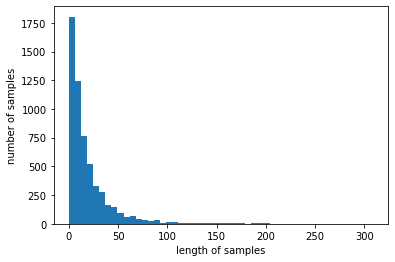

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 91.95663577548522


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
print(len(X_test))
print(len(y_test))

1430
1430


In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('hyol_model9.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
69/72 [===========================>..] - ETA: 0s - loss: 0.5989 - binary_accuracy: 0.7140

72/72 [==============================] - 10s 20ms/step - loss: 0.5976 - binary_accuracy: 0.7148 - val_loss: 0.4821 - val_binary_accuracy: 0.8042
Epoch 2/15
69/72 [===========================>..] - ETA: 0s - loss: 0.4102 - binary_accuracy: 0.8247

72/72 [==============================] - 1s 9ms/step - loss: 0.4114 - binary_accuracy: 0.8221 - val_loss: 0.4579 - val_binary_accuracy: 0.7998
Epoch 3/15
70/72 [============================>.] - ETA: 0s - loss: 0.3345 - binary_accuracy: 0.8679

72/72 [==============================] - 1s 10ms/step - loss: 0.3353 - binary_accuracy: 0.8673 - val_loss: 0.4900 - val_binary_accuracy: 0.7972
Epoch 4/15
70/72 [============================>.] - ETA: 0s - loss: 0.2840 - binary_accuracy: 0.8879

72/72 [==============================] - 1s 9ms/step - loss: 0.2845 - binary_accuracy: 0.8872 - val_loss: 0.5210 - val_binary_accuracy: 0.7867
Epoch 5/15
69/72 [===========================>..] - ETA: 0s - loss: 0.2457 - binary_accuracy: 0.9010

72/72 [==============================] - 1s 9ms/step - loss: 0.2475 - binary_accuracy: 0.9010 - val_loss: 0.5430 - val_binary_accuracy: 0.7955
Epoch 6/15
71/72 [============================>.] - ETA: 0s - loss: 0.2158 - binary_accuracy: 0.9173

72/72 [==============================] - 1s 9ms/step - loss: 0.2158 - binary_accuracy: 0.9174 - val_loss: 0.5709 - val_binary_accuracy: 0.7885
Epoch 6: early stopping


In [ ]:
print(model.layers[0].get_weights()[0])

[[ 0.00233415 -0.01878437 -0.03021345 ...  0.05869    -0.02955328
   0.00088074]
 [ 0.00401106  0.02676569  0.00324941 ... -0.0335274  -0.02646459
  -0.03101581]
 [-0.06491572  0.06320453  0.02902204 ... -0.06633429 -0.0551218
  -0.055652  ]
 ...
 [ 0.03013204  0.03862696  0.03221453 ...  0.00137986 -0.00316714
  -0.00389402]
 [-0.00916102  0.00987444 -0.02645557 ...  0.03388994 -0.02613549
   0.03965287]
 [ 0.00419389 -0.04987378  0.00659305 ...  0.01387069  0.00497102
   0.02707377]]


In [ ]:
#model.save('review_model')
model.save('review_model.h5')

In [ ]:
#loaded_model = load_model('review_model')
loaded_model = load_model('review_model.h5')

print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

45/45 [==============================] - 1s 4ms/step - loss: 0.5178 - binary_accuracy: 0.7790

 테스트 정확도: 0.7790


In [ ]:
import pickle
with open('tokenizer.pickle','wb') as handle:
  pickle.dump(tokenizer, handle)

# **테스트 하기**
런타임 다시시작후 실행

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 646 kB/s 
     |████████████████████████████████| 465 kB 65.3 MB/s 


In [ ]:
import pickle
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

In [ ]:
filepath = '~/content/hyol_model3.h5'

In [ ]:
#loaded_model = load_model('review_model')
loaded_model = load_model(filepath)

OSError: ignored

In [ ]:
print(loaded_model.layers[0].get_weights()[0])

[[ 0.00233415 -0.01878437 -0.03021345 ...  0.05869    -0.02955328
   0.00088074]
 [ 0.00401106  0.02676569  0.00324941 ... -0.0335274  -0.02646459
  -0.03101581]
 [-0.06491572  0.06320453  0.02902204 ... -0.06633429 -0.0551218
  -0.055652  ]
 ...
 [ 0.03013204  0.03862696  0.03221453 ...  0.00137986 -0.00316714
  -0.00389402]
 [-0.00916102  0.00987444 -0.02645557 ...  0.03388994 -0.02613549
   0.03965287]
 [ 0.00419389 -0.04987378  0.00659305 ...  0.01387069  0.00497102
   0.02707377]]


In [ ]:
okt = Okt()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다','로','것','고','원']
max_len = 50

In [ ]:
with open('tokenizer.pickle','rb') as handle:
  tokenizer = pickle.load(handle)

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True)
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences([new_sentence])
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len)
  print(pad_new)
  score = float(loaded_model.predict(pad_new))
  print(score)
  if(score >= 0.8):
    print("{:.2f}% 확률로 5점 리뷰입니다.\n".format(score * 100))
  elif (0.8 >score > 0.6):
    print("{:.2f}% 확률로 4점 리뷰입니다.\n".format(score * 100))
  elif (0.6 >score > 0.4):
    print("{:.2f}% 확률로 3점 리뷰입니다.\n".format((1 - score) * 100))
  elif (0.4 >score > 0.2):
    print("{:.2f}% 확률로 2점 리뷰입니다.\n".format((1 - score) * 100))
  else :
    print("{:.2f}% 확률로 1점 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('더럽고 최악. 불편함. 그리고 직원들 싸가지없음.')

더럽고 최악 불편함 그리고 직원들 싸가지없음
['더럽다', '최악', '불편하다', '그리고', '직원', '들', '싸가지', '없다']
['더럽다', '최악', '불편하다', '그리고', '직원', '싸가지', '없다']
[[417, 120, 199, 107, 12, 337, 4]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0 417 120 199 107  12 337   4]]
1/1 [==============================] - 2s 2s/step
0.0020884580444544554
99.79% 확률로 1점 리뷰입니다.

